In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# <span style="color:orange"> Numerical Simulation Laboratory: Lecture 07</span>

## Exercise 07.1
This exercise aims at estimating the proper length $L$ of the blocks in the Monte Carlo NVT simulation for a system of Lennard-Jones-interacting particles in the canonical ensemble using the autocorrelation function for a large sample of measurements of the internal energy per particle and the pressure.

The simulation is performed in three different experimental situations:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

Densities and temperatures are in LJ units, conversion to SI is made with the following parameters: $\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu (notice they are all the same we used in Lec 4).
### Stabilization
First of all we need to make sure that the system is at equilibrium while we carry out our measurements (or at least that the number of steps it takes to settle is a tiny bit of the total simulation length). In order to do that we run a trial simulation for each of the three phases starting from a perfect FCC configuration for $M=1000$ steps. We print instant values of the potential energy per particle $U/N$ and the pressure $P$ and plot them in order to visually infer the number of steps needed to reach an equilibum configuration. 

In [2]:
def load_from_file(filename, data):
    file=open(filename)
    i=0
    for lines in file.readlines():
        data[i]=lines.split()[1]
        i+=1
    file.close()

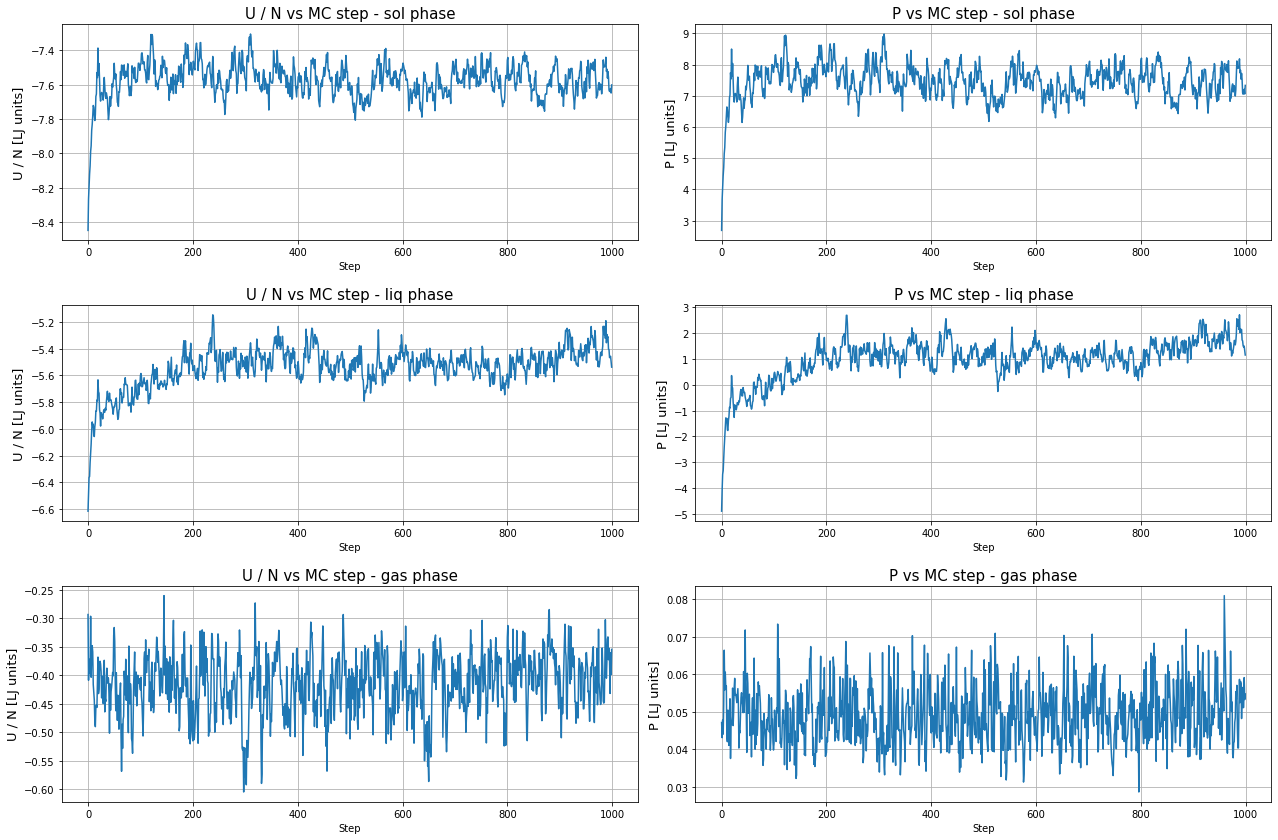

In [3]:
M=1000
x=np.arange(M)
data=np.zeros((6, M))
phase=["sol", "liq", "gas"]
j=0

for i in range(0, 6, 2):
    load_from_file("Es_lezione_07/epot_" + phase[j] + ".dat", data[i])
    load_from_file("Es_lezione_07/press_" + phase[j] + ".dat", data[i+1])
    j+=1
        
f, canvas=plt.subplots(nrows=3, ncols=2)
title = ["U / N" , "P"]

for i in range(3):
    for j in range(2):
        canvas[i][j].plot(x, data[2*i+j])
        canvas[i][j].set_ylabel(title[j] + " [LJ units]", fontsize=13)
        canvas[i][j].set_xlabel("Step")
        canvas[i][j].set_title(title[j] + " vs MC step - " + phase[i] + " phase", fontsize=15)
        canvas[i][j].grid(True)

plt.subplots_adjust(left=-0.5, bottom=-1.5, right=2.3, top=1.2, wspace=0.1, hspace=0.3)

The solid and gaseous phases seem to reach equilibrum almost immediately. As for the liquid phase, it takes roughly 200 steps for both the pressure and the potential energy to settle.
In each case the final configuration corresponds to a stabilized state, so we save it and we are going to use each of them (in the correct order) in the following. 

### Solid phase
Starting from the configuration above evaluated, we run the simulation for $M=703028$ steps (it took too long to run the algorithm for the suggested $5\times 10^5$ steps) and print both the potential energy per particle and the pressure. We aim at estimating the number of steps per block in order to get rid of autocorrelation effects.

A first rather rough approximation is obtained by evaluating the autocorrelation functions $\chi$ for both the potential energy and the pressure and having a look at them. We should not expect this method to give a very precise answer because we won't be seeing a sudden drop to zero of $\chi$ from some value of $\tau$ on (i.e. a threshold from which every autocorrelation effect vanishes), so our estimation is doomed to depend on the arbitrary choice of a value below which we are to consider $\chi$ negligible.

In [14]:
def evaluate_ac(data, tau):
    L=len(data)-tau
    x_t=0
    x_ttau=0
    x_tau=0
    x_t2=0
    
    for i in range(L):
        x_t+=data[i]
        x_ttau+=data[i]*data[i+tau]
        x_tau+=data[i+tau]
        x_t2+=data[i]**2
    
    return (L*x_ttau-x_t*x_tau)/(L*x_t2-x_t**2)

def load_from_file(filename, data):
    file=open(filename)
    for lines in file.readlines():
        data.append(float(lines.split()[1]))
    file.close()

In [17]:
U=[]
P=[]

load_from_file("Es_lezione_07/epot_sol_autocorr.dat", U)
load_from_file("Es_lezione_07/press_sol_autocorr.dat", P)

Tau=150
x=np.arange(Tau)
Ac_U=np.zeros(Tau)
Ac_P=np.zeros(Tau)

for tau in range(Tau):
    Ac_U[tau]=evaluate_ac(U, tau)
    Ac_P[tau]=evaluate_ac(P, tau)

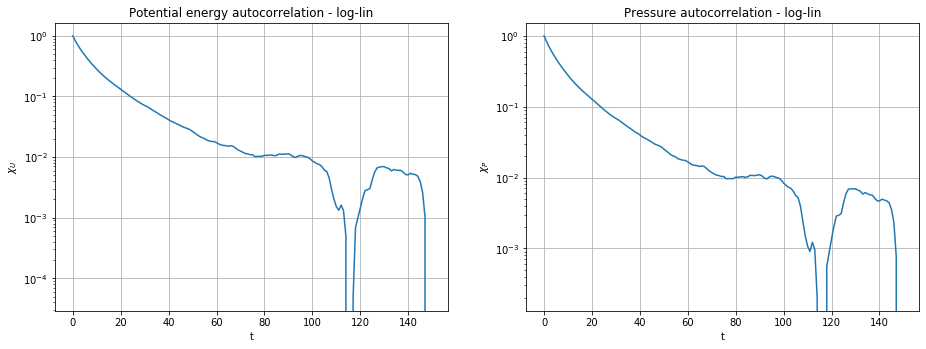

In [18]:
f, canvas=plt.subplots(nrows=1, ncols=2)

canvas[0].plot(x, Ac_U)
canvas[0].set_ylabel("$\chi_U$")
canvas[0].set_xlabel("t")
canvas[0].set_title("Potential energy autocorrelation - log-lin")
canvas[0].grid(True)
canvas[0].set_yscale("log")

canvas[1].plot(x, Ac_P)
canvas[1].set_ylabel("$\chi_P$")
canvas[1].set_xlabel("t")
canvas[1].set_title("Pressure autocorrelation - log-lin")
canvas[1].grid(True)
canvas[1].set_yscale("log")

plt.subplots_adjust(left=0.2, bottom=0.2, right=2.2, top=1.2, wspace=0.2, hspace=0.4)

The autocorrelation is plotted in scale log-lin to immediately recognize whether it is well-approximated by a function $\chi(\tau)=\exp\bigl[-\tau/\tau_C\bigr]$ for some $\tau_C$. The answer is negative because the plot is not even close to being linear for it decays much slower than the straight line that connect the first few points. If we insist on pretending it can be approximated by such a function, a very rough upper bound for $\tau_C$ can be easily obtainted just by staring at the plot: $\tau_C<20$; since the decay is slower-than-exponential, an exceeding guess may turn out not to be that bad. As a consequence, we can set a lower bound to the length of each block $L>2\tau_C\approx 40$.

In order to get a more precise answer to our question we evaluate blocking averages for the given sample for increasing number of blocks $N$. We, then, plot the uncertainty as a function of the length $L=M/N$ of each block: we expect to observe a stabilization after a certain value $\tilde{L}$. From then on it is pointless to further enlarge the blocks, so we take $\tilde{L}$ as the lower bound that ensures negligible autocorrelation.

In [19]:
def blocking_method_error(data, L):
    M=len(data)
    N=int(M/L)
    ave=np.zeros(N)
    ave2=np.zeros(N)
    
    for i in range(N):
        accu=0
        for j in range(L):
            accu+=data[L*i+j]
        ave[i]=accu/L
        ave2[i]=(ave[i])**2
        
    accu=0
    accu2=0
    for i in range(N):
        accu+=ave[i]
        accu2+=ave2[i]
        
    accu/=N
    accu2/=N
            
    return np.sqrt((accu2 - accu**2)/N)   

In [20]:
L=np.arange(10, 5000, 50)
errU=np.zeros(len(L))
errP=np.zeros(len(L))

i=0
for l in L:
    errU[i]=blocking_method_error(U, l)
    errP[i]=blocking_method_error(P, l)
    i+=1

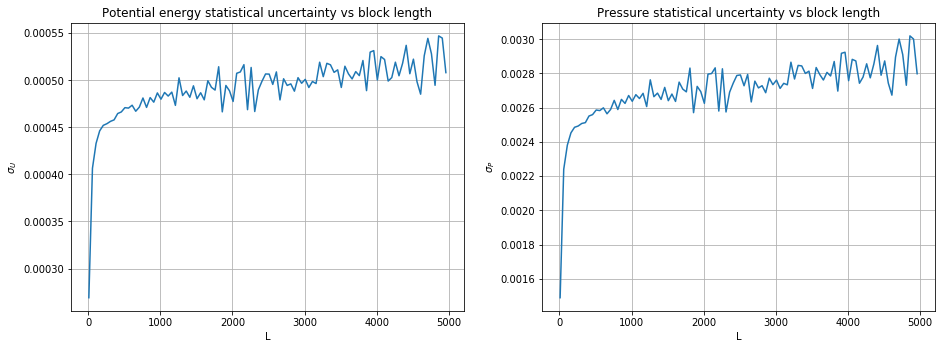

In [21]:
f, canvas=plt.subplots(nrows=1, ncols=2)

canvas[0].plot(L, errU)
canvas[0].set_ylabel("$\sigma_U$")
canvas[0].set_xlabel("L")
canvas[0].set_title("Potential energy statistical uncertainty vs block length")
canvas[0].grid(True)

canvas[1].plot(L, errP)
canvas[1].set_ylabel("$\sigma_P$")
canvas[1].set_xlabel("L")
canvas[1].set_title("Pressure statistical uncertainty vs block length")
canvas[1].grid(True)

plt.subplots_adjust(left=0.2, bottom=0.2, right=2.2, top=1.2, wspace=0.2, hspace=0.4)

From the plots we see that a settlement in the statistical uncertainty occurs roughly after we reach a block length of 1500-2000 steps.

### Liquid phase
We follow the same procedure as before for $M=5\times 10^5$ steps.

In [22]:
Ul=[]
Pl=[]

load_from_file("Es_lezione_07/epot_liq_autocorr.dat", Ul)
load_from_file("Es_lezione_07/press_liq_autocorr.dat", Pl)

x=np.arange(Tau)
Ac_Ul=np.zeros(Tau)
Ac_Pl=np.zeros(Tau)

for tau in range(Tau):
    Ac_Ul[tau]=evaluate_ac(Ul, tau)
    Ac_Pl[tau]=evaluate_ac(Pl, tau)

500000


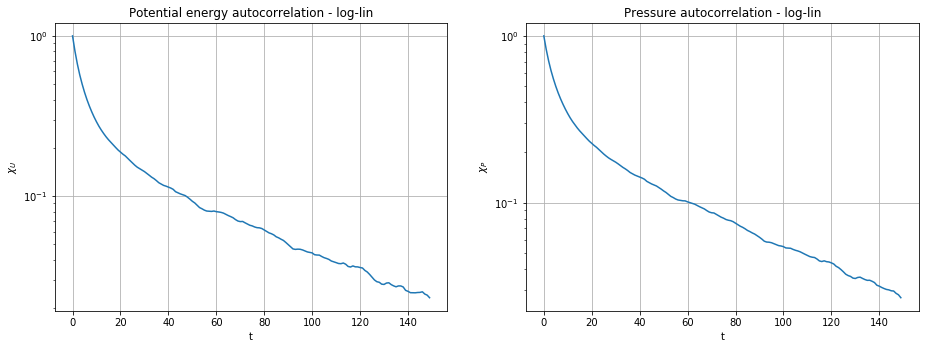

In [23]:
f, canvas=plt.subplots(nrows=1, ncols=2)

canvas[0].plot(x, Ac_Ul)
canvas[0].set_ylabel("$\chi_U$")
canvas[0].set_xlabel("t")
canvas[0].set_title("Potential energy autocorrelation - log-lin")
canvas[0].grid(True)
canvas[0].set_yscale("log")

canvas[1].plot(x, Ac_Pl)
canvas[1].set_ylabel("$\chi_P$")
canvas[1].set_xlabel("t")
canvas[1].set_title("Pressure autocorrelation - log-lin")
canvas[1].grid(True)
canvas[1].set_yscale("log")

plt.subplots_adjust(left=0.2, bottom=0.2, right=2.2, top=1.2, wspace=0.2, hspace=0.4)

The decay of the autocorrelation is not only slower than exponential but is even slower than what we observed the solid phase. As a consequence, an estimation, as rough as it may be, of the critical time $\tau_C$ is pointless (it has already proven its unreliability in a case where the decay appeared to be more exponential-like than the one at stake) . At most, since both $\chi$-s are monotonically descreasing, one could set arbitrarily a threshold below which the autocorrelation is considered negligible. If we require $\chi<10^{-1}$ (which is not a very good approximation by the way), from the plots we see that it must be $L>60$.

In [13]:
errUl=np.zeros(len(L))
errPl=np.zeros(len(L))

i=0
for l in L:
    errUl[i]=blocking_method_error(Ul, l)
    errPl[i]=blocking_method_error(Pl, l)
    i+=1

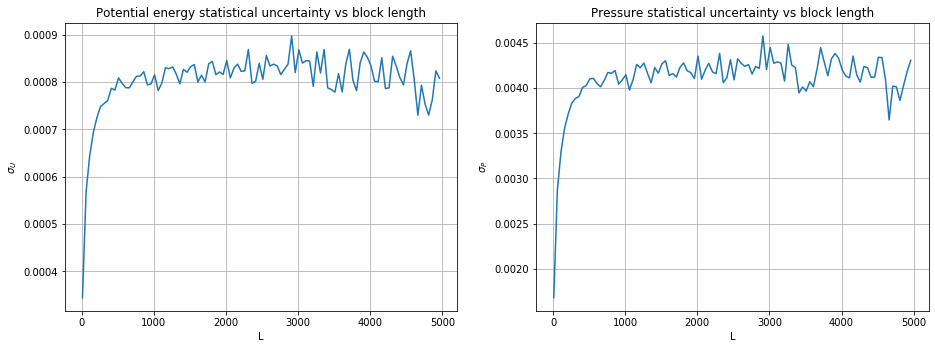

In [14]:
f, canvas=plt.subplots(nrows=1, ncols=2)

canvas[0].plot(L, errUl)
canvas[0].set_ylabel("$\sigma_U$")
canvas[0].set_xlabel("L")
canvas[0].set_title("Potential energy statistical uncertainty vs block length")
canvas[0].grid(True)

canvas[1].plot(L, errPl)
canvas[1].set_ylabel("$\sigma_P$")
canvas[1].set_xlabel("L")
canvas[1].set_title("Pressure statistical uncertainty vs block length")
canvas[1].grid(True)

plt.subplots_adjust(left=0.2, bottom=0.2, right=2.2, top=1.2, wspace=0.2, hspace=0.4)

The uncertainties seem to stabilize after the block length has reached approximately 2000 steps.

### Gas phase
Same procedure yet again, number of steps $M=5\times 10^5$.

In [24]:
Ug=[]
Pg=[]

load_from_file("Es_lezione_07/epot_gas_autocorr.dat", Ug)
load_from_file("Es_lezione_07/press_gas_autocorr.dat", Pg)

#print(len(Ug))

x=np.arange(Tau)
Ac_Ug=np.zeros(Tau)
Ac_Pg=np.zeros(Tau)

for tau in range(Tau):
    Ac_Ug[tau]=evaluate_ac(Ug, tau)
    Ac_Pg[tau]=evaluate_ac(Pg, tau)

500000


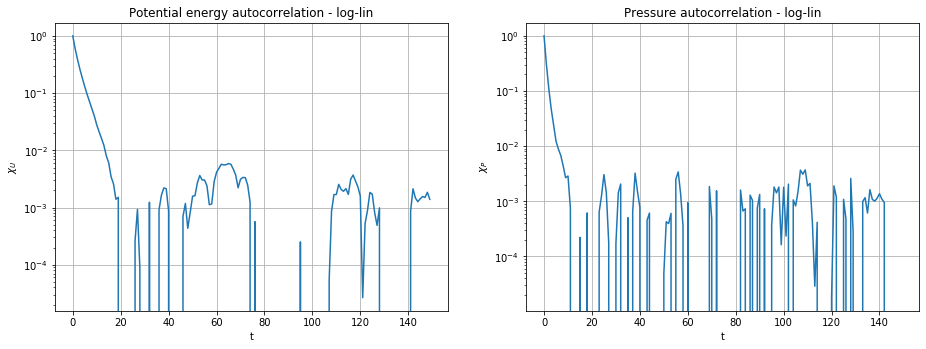

In [25]:
f, canvas=plt.subplots(nrows=1, ncols=2)

canvas[0].plot(x, Ac_Ug)
canvas[0].set_ylabel("$\chi_U$")
canvas[0].set_xlabel("t")
canvas[0].set_title("Potential energy autocorrelation - log-lin")
canvas[0].grid(True)
canvas[0].set_yscale("log")

canvas[1].plot(x, Ac_Pg)
canvas[1].set_ylabel("$\chi_P$")
canvas[1].set_xlabel("t")
canvas[1].set_title("Pressure autocorrelation - log-lin")
canvas[1].grid(True)
canvas[1].set_yscale("log")

plt.subplots_adjust(left=0.2, bottom=0.2, right=2.2, top=1.2, wspace=0.2, hspace=0.4)

Both autocorrelation functions decay much faster than both previous cases: when $L\approx 20$ is reached we see that both the $\chi$-s have reached values very close to zero and start oscillating. We therefore expect the block length needed for the gas-phase simulation to stabilize the uncertainty to be much shorter. The reasons for such a fast decay are both the higher temperature of the gaseous phase (i.e. higher energy states can be easily explored through the sample of the canonical ensemble PDF) and the lower density (resulting in a bigger simulation box that allows particle to move further apart one another).

In [17]:
errUg=np.zeros(len(L))
errPg=np.zeros(len(L))

i=0
for l in L:
    errUg[i]=blocking_method_error(Ug, l)
    errPg[i]=blocking_method_error(Pg, l)
    i+=1

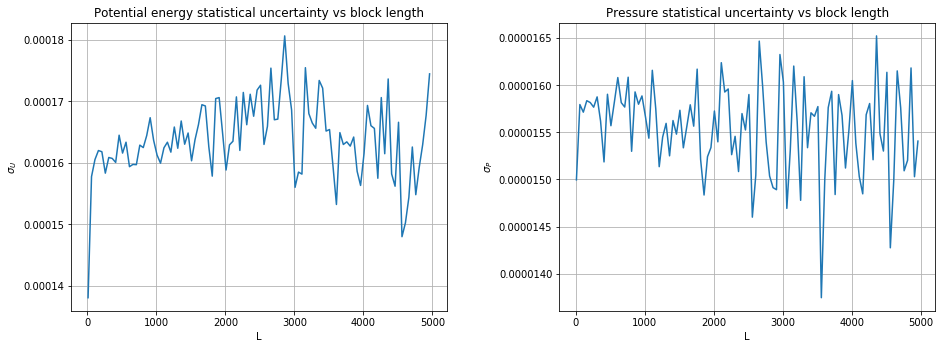

In [18]:
f, canvas=plt.subplots(nrows=1, ncols=2)

canvas[0].plot(L, errUg)
canvas[0].set_ylabel("$\sigma_U$")
canvas[0].set_xlabel("L")
canvas[0].set_title("Potential energy statistical uncertainty vs block length")
canvas[0].grid(True)

canvas[1].plot(L, errPg)
canvas[1].set_ylabel("$\sigma_P$")
canvas[1].set_xlabel("L")
canvas[1].set_title("Pressure statistical uncertainty vs block length")
canvas[1].grid(True)

plt.subplots_adjust(left=0.2, bottom=0.2, right=2.2, top=1.2, wspace=0.3, hspace=0.4)

As expected, the uncertainties already stabilize after a block length of $L\approx 1000$ is reached.

## Exercise 07.4

### Solid phase
According to the results of Ex 01, the solid phase needs blocks of at least a couple of thousands in order to reach un-autocorrelated configuration. Hence, we run the simulation for $N=100$ blocks of length $L=2500$ each. We plot the esteems for the potential energy per particle and pressure as the number of blocks increases and the radial distribution as a function of the distance between particles. The distribution is evaluated both with the NVT and the NVE algorithm, while for the other quantities we employ only the former. Plots are in SI units.

In [26]:
def load_obs(filename, data, err):
    file=open(filename)
    for line in file.readlines():
        l=line.split()
        data.append(float(l[2]))
        err.append(float(l[3]))
    file.close()

def load_g(filename, r, g, err):
    file=open(filename)
    for line in file.readlines():
        l=line.split()
        r.append(float(l[0]))
        g.append(float(l[1]))
        err.append(float(l[2]))
    file.close()

In [27]:
sigma=0.34E-9
epsilon=120
m=39.984*1.66054E-27
kB=1.380649E-23
N=100

x=np.arange(N)
U=[]
errU=[]
P=[]
errP=[]
r1=[]
g1=[]
errg1=[]
r2=[]
g2=[]
errg2=[]

load_obs("Es_lezione_07/epot_sol_NVT.dat", U, errU)
load_obs("Es_lezione_07/press_sol_NVT.dat", P, errP)
load_g("Es_lezione_07/g_sol_NVT.dat", r1, g1, errg1)
load_g("Es_lezione_07/g_sol_NVE.dat", r2, g2, errg2)

U=[epsilon*kB*E for E in U]
errU=[epsilon*kB*errE for errE in errU]
P=[p*epsilon*kB/sigma**3 for p in P]
errP=[errp*epsilon*kB/sigma**3 for errp in errP]
r1=[sigma*r for r in r1]
r2=[sigma*r for r in r2]
# g left unchanged in SI units

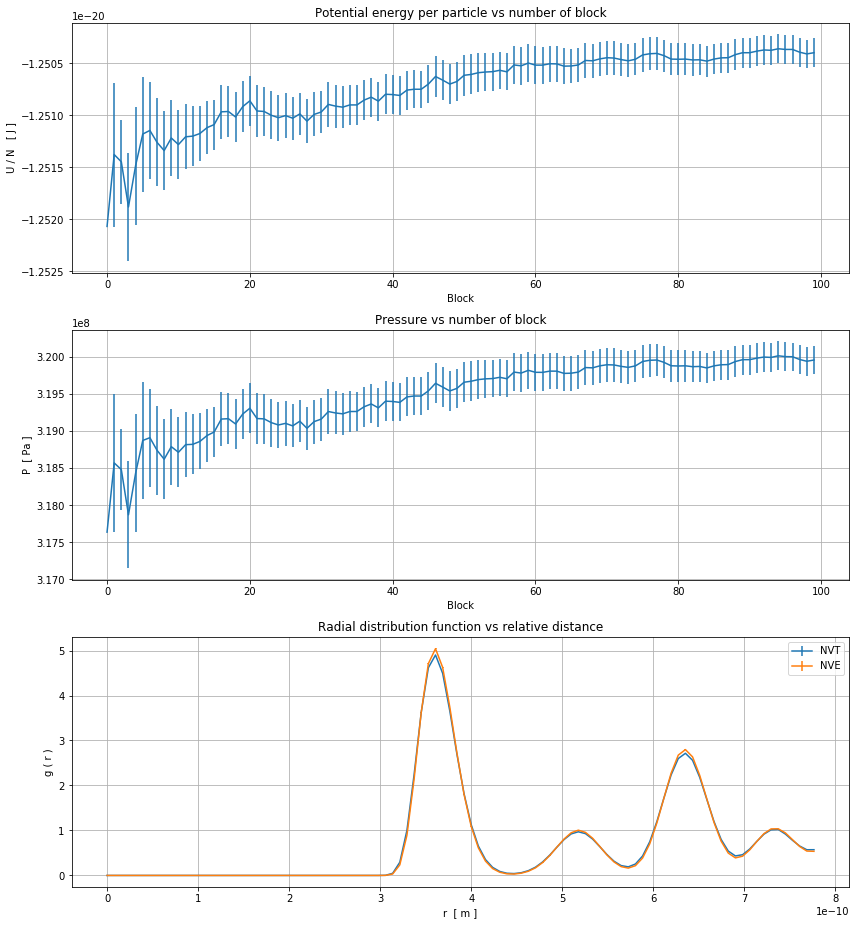

In [32]:
f, canvas=plt.subplots(nrows=3, ncols=1)

canvas[0].errorbar(x, U, yerr=errU)
canvas[0].set_title("Potential energy per particle vs number of block")
canvas[0].set_xlabel("Block")
canvas[0].set_ylabel("U / N   [ J ]")
canvas[0].grid(True)

canvas[1].errorbar(x, P, yerr=errP)
canvas[1].set_title("Pressure vs number of block")
canvas[1].set_xlabel("Block")
canvas[1].set_ylabel("P  [ Pa ]")
canvas[1].grid(True)

canvas[2].errorbar(r1, g1, yerr=errg1, label="NVT")
canvas[2].errorbar(r2, g2, yerr=errg2, label="NVE")
canvas[2].set_title("Radial distribution function vs relative distance")
canvas[2].set_xlabel("r  [ m ]")
canvas[2].set_ylabel("g ( r )")
canvas[2].legend()
canvas[2].grid(True)

plt.subplots_adjust(left=0.2, bottom=0, right=2., top=3, wspace=0.4, hspace=0.23)

The radial distribution function well depict the repulsive core of the interaction (the probability of finding particles closer than $3\overset{\,\circ}{A}$ is essentially zero. Above such distance, the mutual positions are "discretized", meaning the distribution shows very definite ups and downs and it is hence much more likely to "measure" particle distances around the highs while almost no couple will put themselves at positions corresponding to a low. The distributions measured with the two algorithms overlap almost perfectly (at least at this scale, where uncertainties are almost invisibile). More visible discrepancies occur at the maxima of the distributions.

### Liquid phase
The liquid exhibits the slowest decay of correlations, hence we will have to perform longer blocks. We use $N=100$ blocks with $L=3000$ steps each. Quantities displayed are the same as for the solid phase.

In [34]:
Ul=[]
errUl=[]
Pl=[]
errPl=[]
rl1=[]
gl1=[]
errgl1=[]
rl2=[]
gl2=[]
errgl2=[]

load_obs("Es_lezione_07/epot_liq_NVT.dat", Ul, errUl)
load_obs("Es_lezione_07/press_liq_NVT.dat", Pl, errPl)
load_g("Es_lezione_07/g_liq_NVT.dat", rl1, gl1, errgl1)
load_g("Es_lezione_07/g_liq_NVE.dat", rl2, gl2, errgl2)

Ul=[epsilon*kB*E for E in Ul]
errUl=[epsilon*kB*errE for errE in errUl]
Pl=[p*epsilon*kB/sigma**3 for p in Pl]
errPl=[errp*epsilon*kB/sigma**3 for errp in errPl]
rl1=[sigma*r for r in rl1]
rl2=[sigma*r for r in rl2]

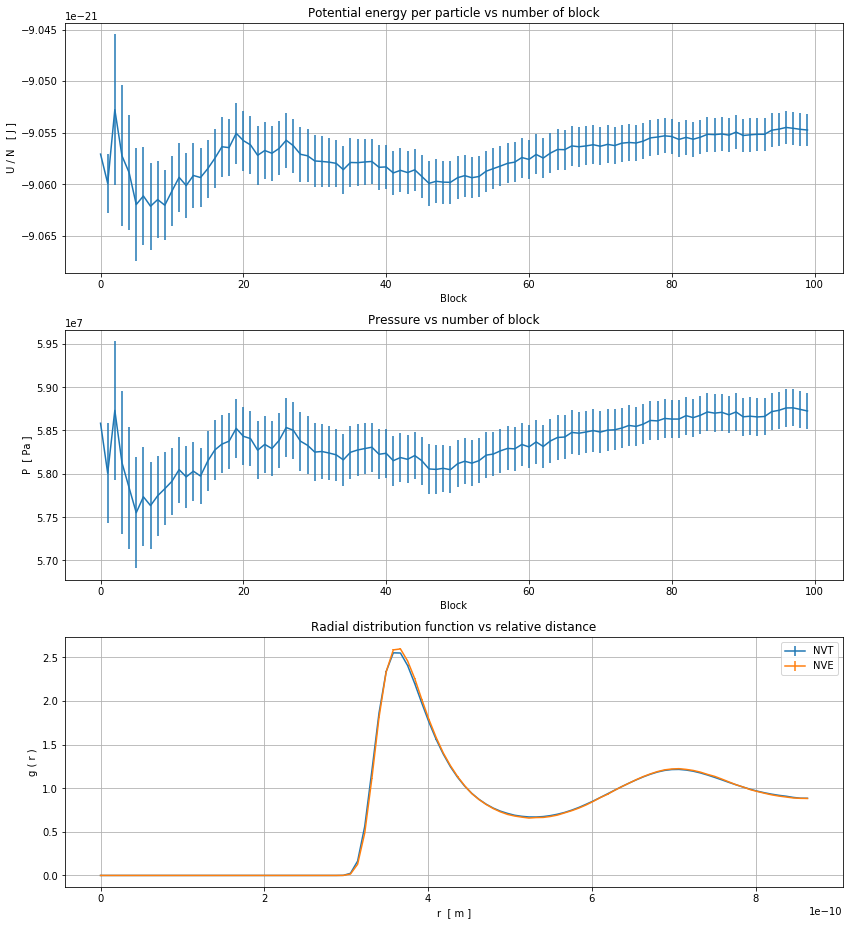

In [35]:
f, canvas=plt.subplots(nrows=3, ncols=1)

canvas[0].errorbar(x, Ul, yerr=errUl)
canvas[0].set_title("Potential energy per particle vs number of block")
canvas[0].set_xlabel("Block")
canvas[0].set_ylabel("U / N   [ J ]")
canvas[0].grid(True)

canvas[1].errorbar(x, Pl, yerr=errPl)
canvas[1].set_title("Pressure vs number of block")
canvas[1].set_xlabel("Block")
canvas[1].set_ylabel("P  [ Pa ]")
canvas[1].grid(True)

canvas[2].errorbar(rl1, gl1, yerr=errgl1, label="NVT")
canvas[2].errorbar(rl2, gl2, yerr=errgl2, label="NVE")
canvas[2].set_title("Radial distribution function vs relative distance")
canvas[2].set_xlabel("r  [ m ]")
canvas[2].set_ylabel("g ( r )")
canvas[2].legend()
canvas[2].grid(True)

plt.subplots_adjust(left=0.2, bottom=0., right=2, top=3, wspace=0.4, hspace=0.23)

Once again there is a repulsive core but after a very definite bump the radial distribution flattens out (highs and lows still occur but are far less pronounced). Consequently, particles will have a wider "freedom" to place themselves at any distance (larger than $3\overset{\,\circ}{A}$ of course) and the system is thus less "ordered".

Once again, the radial distributions computed with the two algorithm fairly agree (as far as one can tell from the scale of the plot) and the top of the first bump is again the point where the discrepanices are bigger (still very slight though).

### Gaseous phase
The gaseous phase has shown the fastest tendency of the configuration to get uncorrelated, consequently shorter blocks can be used. We run the simulation for $N=100$ blocks of $L=2000$ steps each and produce measurements of the same three quantities.

In [36]:
Ug=[]
errUg=[]
Pg=[]
errPg=[]
rg1=[]
gg1=[]
errgg1=[]
rg2=[]
gg2=[]
errgg2=[]

load_obs("Es_lezione_07/epot_gas_NVT.dat", Ug, errUg)
load_obs("Es_lezione_07/press_gas_NVT.dat", Pg, errPg)
load_g("Es_lezione_07/g_gas_NVT.dat", rg1, gg1, errgg1)
load_g("Es_lezione_07/g_gas_NVE.dat", rg2, gg2, errgg2)

Ug=[epsilon*kB*E for E in Ug]
errUg=[epsilon*kB*errE for errE in errUg]
Pg=[p*epsilon*kB/sigma**3 for p in Pg]
errPg=[errp*epsilon*kB/sigma**3 for errp in errPg]
rg1=[sigma*r for r in rg1]
rg2=[sigma*r for r in rg2]

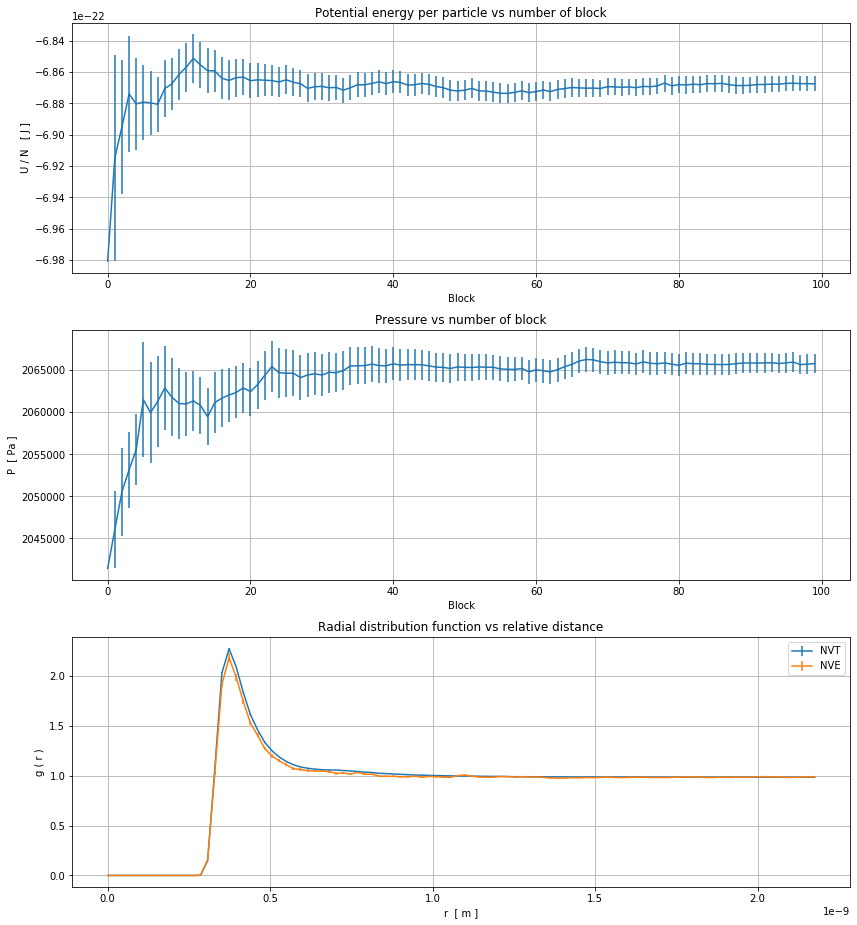

In [37]:
f, canvas=plt.subplots(nrows=3, ncols=1)

canvas[0].errorbar(x, Ug, yerr=errUg)
canvas[0].set_title("Potential energy per particle vs number of block")
canvas[0].set_xlabel("Block")
canvas[0].set_ylabel("U / N   [ J ]")
canvas[0].grid(True)

canvas[1].errorbar(x, Pg, yerr=errPg)
canvas[1].set_title("Pressure vs number of block")
canvas[1].set_xlabel("Block")
canvas[1].set_ylabel("P  [ Pa ]")
canvas[1].grid(True)

canvas[2].errorbar(rg1, gg1, yerr=errgg1, label="NVT")
canvas[2].errorbar(rg2, gg2, yerr=errgg2, label="NVE")
canvas[2].set_title("Radial distribution function vs relative distance")
canvas[2].set_xlabel("r  [ m ]")
canvas[2].set_ylabel("g ( r )")
canvas[2].legend()
canvas[2].grid(True)

plt.subplots_adjust(left=0.2, bottom=0, right=2, top=3, wspace=0.4, hspace=0.23)

The repulsive core is of course still present (its pronounced increase is due to the box side being density-dependent, and the density of the gas is manifestly smaller than those of the other two phases), then the distribution shows a single bump and an immediate flattening which causes the system to be much less "ordered" in the sense that each couple of particles will, with roughly constant probability, place itself in any mutual position bigger than about $0.5$nm.

At distances above roughly $1$nm the curves obtained with the two algorithms are undistinguishable, while for $r$ between the end of the core and such value the NVT curve is slightly (but visibly) higher. In such interval uncertainties for the NVE curve are this time perceivable (still quite small though).